Source: https://pennylane.ai/qml/demos/tutorial_haar_measure#nandc2000

"Assume that $U$ is sampled uniformly at rangom from the Haar measure".  

We're going to unravel this cryptic statement adn take an in-depth look at what is means. You'll gain an understanding of the general concept of a *measure*, the Haar measure and its special properties, and you'll learn how to sample from it using tools available in PennyLane and other scientific computing frameworks. By the end of this demo, you'll be able to include that important statement in your own work with confidence!

## Measure  
Measure theory is a branch of mathematics that studies things that are measurable - think length, area, or volume, but generalized to mathematical spaces and even higher dimensions. Loosely, the measure tells you about how "stuff" is distributed and concentrated in a mathematical set or space. An intuitive way to understand the measure is to think about a sphere. An arbitrary point on a sphere can be parameterized by three numbers - depending on what you're doing, you may use Cartesian coorinates $(x,y,z)$, or it may be more convenient to use spherical coordinates $(\rho, \phi, \theta)$  

extra terms that we have to add to the integral(for example, $\rho^2 sin \theta$ in spherical polar coordinates) constitute the *measure*. The measure weights portions of the sphere differently depending on where they are in the space. While we need to know the measrue to properly integrate over the sphere, knowledge of the measure also gives us the means to perform another important task, that of sampling points in the space uniformly at random. We can't simply sample each parameter from the uniform distribution over its domain - as we experienced already, this doesn't take into account how the sphere is spread out over space. The measure describes the distribution of each parameter and gives a recipe for sampling them in order to obtain something properly uniform. 

## The Harr measure  
Operations in quantum computing are described by unitary matrices. Unittary matrices, like points on a sphere, can be expressed in terms of a fixed set of coordinates, or parameters. For example, the most general single-qubit rotation implemented in PennyLane ```Rot``` is expressed in terms of three pararmeters like so,  
$$U(\phi, \theta, \omega) = \begin{pmatrix} e^{-i(\phi+\omega)/2}cos(\theta/2) & e^{-i(\phi-\omega)/2}sin(\theta/2) \\ e^{-i(\phi-\omega)/2}sin(\theta/2)  & e^{i(\phi+\omega)/2}cos(\theta/2)\end{pmatrix}$$
We can perfrom operations on elements of this group, such as apply functions to them, integrate over them, or sample uniformly over them, just as we can do to points on a sphere. When we do such tasks with respect to the sphere, we have to add the measure in order to properly weight the different regions of space. The *Haar measure* provides the analogous terms we need for working with the unitary group    

### Single-qubit Haar measure  
The single-qubit case provides a particularly nice entry point because we can continue our comparison to spheres by visualizing single-qubit states on the Bloch sphere. As expressed above, the measure provides a recipe for sampling elements of the unitary group in a properly uniform manner, given the structure of the group. One useful consequence of this is that it provides a method to sample quantum states uniformly at random - we simply generate Haar-random unitaries, and apply them to a fixed basis state such as $|0\rangle$  

We'll see how this works in good time. First, we'll take a look at what happens when we ignore the measure and do things wrong. Suppose we sample quantum states by applying unitaries obtained by the aprametrization above, but sample the angels $\omega, \phi, and \theta$ from the flat uniform distibution b/w $[0, 2\pi)$ (fun fact: there is a measure implicit in this knid of sampling too! It just has a constant value, because each point is equally likely to be sampled)

In [15]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

dev = qml.device('default.mixed', wires = 1) # use the mixed state simulatro to save some steps in plotting later

@qml.qnode(dev)
def not_a_haar_random_unitary():
    phi, theta, omega = np.random.uniform(0, 2*np.pi, size = 3)
    qml.Rot(phi, theta, omega, wires = 0)
    return qml.state()

num_samples = 2025

not_harr_samples = [not_a_haar_random_unitary() for _ in range(num_samples)]

In order to plot these on the Bloch sphere, we'll need to do one more step, and convert the quantum states into Bloch vectors.

In [16]:
not_harr_samples[0]

array([[0.59273692+0.j        , 0.40312726-0.28087057j],
       [0.40312726+0.28087057j, 0.40726308+0.j        ]])

In [19]:
X = qml.X.compute_matrix()
Y = qml.Y.compute_matrix()
Z = qml.Z.compute_matrix()

def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

not_haar_bloch_vectors = np.array([convert_to_bloch_vector(rho) for rho in not_harr_samples])

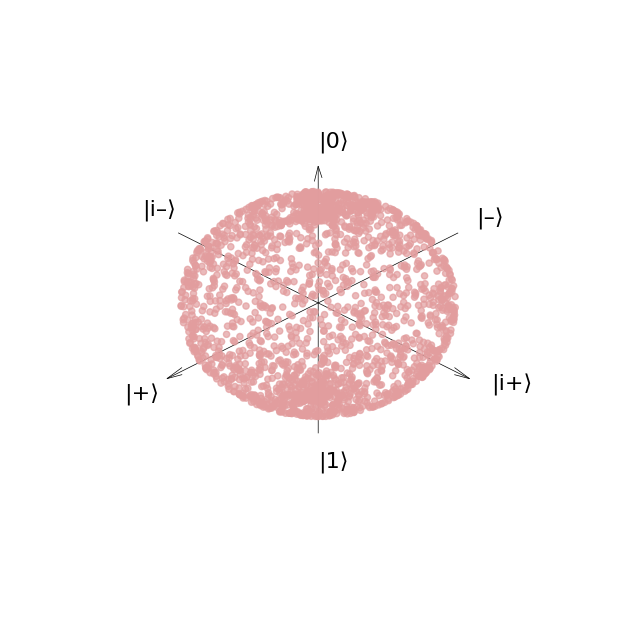

In [38]:
def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d') # 111은 1행 1열의 첫번째, projection에서 3d 명시해야 Axes3D 객체가 생성됨
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1) 
    # subplots_adjust는 그림판에서 axes가 차지하는 영역을 조절하는 함수임 (00)은 왼쪽 아래 (11)은 오른쪽 위 끝
    # 기본값으로는 (0.125, 0.9, 0.1, 0.9)로 설정되어 있어 여백이 포함되지만, 여기서는 여백 없앰

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45) # 위아래 각도 30도, 좌우회전 45도 각도로 시점 설정

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)
    # quiver는 화살표를 설정하는 함수, (x,y,z)에서 (u,v,w)방향으로 화살표 그림  3은 길이를 나타내므로 -1.5 + 3 = 1.5에 위치하게 됨

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16) # 이 좌표에 텍스트 삽입
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='#e29d9e', alpha= 0.7
    )
    plt.show()

plot_bloch_sphere(not_haar_bloch_vectors)

딱 봐도 균일 분포서 뽑은 것들은 poles에 clustering이 존재.  
우리는 적절한 Haar measure로부터 샘플하고 파라미터마다 적절히 가중을 줘야함  
The parameter that we will have to weight differently is $\theta$, and in fact the adjustment in measure is identical to that we had to do with the polar axis of the sphere $i.e., sin\theta$. \rho는 1로 고정되어있기 때문에 고려 안해도 됨. In order to sample the $\theta$ uniformly at random in this context, we must sample from the distribution $Pr(\theta) = sin \theta$. We can accomplish this by setting up a custom probability distribution with ```rv_continuous``` in ```scipy```

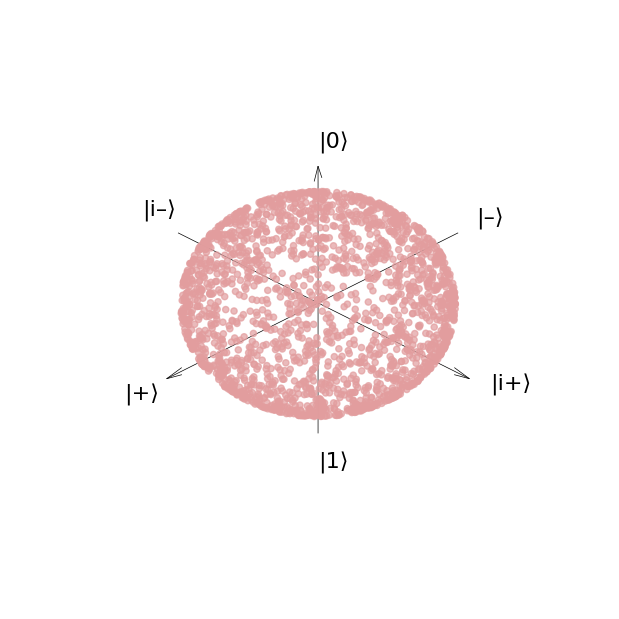

In [39]:
from scipy.stats import rv_continuous

class sin_prob_dist(rv_continuous):
    "Custom distribution with sin(x) PDF"
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)  # 아래 정의된 0~pi까지 적분하면 값이 2인데, 1로 정규화 해야해서 0.5를 곱함

# samples of theta should be drawn from b/w 0 and pi    
sin_sampler = sin_prob_dist(a=0, b= np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2) # Sample phi and omega as normal
    theta = sin_sampler.rvs(size=1)[0]  # Sample theta from our new distribution
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

haar_samples = [haar_random_unitary() for _ in range(num_samples)]
haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in haar_samples])

plot_bloch_sphere(haar_bloch_vectors)

We see that when we use the correct measure, our qubit states are now much better distributed over the sphere. Putting this information together, we can now write the explicit form for the single qubit Haar measure:  
$$d\mu_2 = sin\theta d\theta d\omega d\phi$$

### Show me more math!